# Basic Classifying VAE for MNIST Database

In [1]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch
import pprint
import numpy as np
import numpy.random as random
import datetime
from src.pytorch_cl_vae.model import ClVaeModel
import matplotlib.pyplot as plt
from collections import defaultdict

## 1 - Specify parameters for to the VAE and training

In [2]:
params = {
    'batch_size': 100,
    'num_epochs': 5,
    'latent_dim': 2,
    'encoder_hidden_size': 512,
    'decoder_hidden_size': 512,
    'classifier_hidden_size': 512,
    'vae_learning_rate': 0.0001,
    'classifier_learning_rate': 0.0001,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'data_dir': '../data'
}

## 2 - Fetch MNIST

In [3]:
mnist = fetch_mldata('MNIST original', data_home=params['data_dir'])
mnist.data = mnist.data / 255
num_samples, input_dim = mnist.data.shape
num_classes = len(np.unique(mnist.target))
lb = preprocessing.LabelBinarizer()
lb.fit(mnist.target)
params['classes_dim'] = [num_classes]
params['original_dim'] = input_dim
print('MNIST db has been successfully loaded, stored in the: "{}"'.format(params['data_dir'] + '/mldata'))
# split data to train and test subsets
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.1, random_state=0)
print("| Train subset shape:{} | Test subset shape:{} |".format(X_train.shape, X_test.shape))

MNIST db has been successfully loaded, stored in the: "../data/mldata"
| Train subset shape:(63000, 784) | Test subset shape:(7000, 784) |


## 3 - Create Model

In [4]:
# Initialize ClVaeModel
model = ClVaeModel(**params)
print("Model successfully initialized with params: ")
pprint.PrettyPrinter(indent=4).pprint(params)

train_losses = []
train_accuracies = []

Model successfully initialized with params: 
{   'batch_size': 100,
    'classes_dim': [10],
    'classifier_hidden_size': 512,
    'classifier_learning_rate': 0.0001,
    'data_dir': '../data',
    'decoder_hidden_size': 512,
    'encoder_hidden_size': 512,
    'latent_dim': 2,
    'log_dir': '../data/logs',
    'model_dir': '../data/models',
    'num_epochs': 5,
    'original_dim': 784,
    'vae_learning_rate': 0.0001}


## 4 - Train

In [5]:
save_each_steps = 500

# Train loop
train_step_i = 0
for epoch in range(params['num_epochs']):
    print('\nepoch {} out of {}'.format(epoch + 1, params['num_epochs']))
    for i in range(X_train.shape[0] // params['batch_size']):
        # Sample batch
        idx = random.choice(np.arange(0, X_train.shape[0]), params['batch_size'])
        x_batch = torch.from_numpy(X_train[idx]).float()
        y_batch = lb.transform(y_train[idx])
        y_batch = [torch.from_numpy(y_batch).float()]
        step_losses, step_accuracies = model.train_step(x_batch, y_batch)

#         step_losses = [loss.sum().detach().numpy() for loss in step_losses]
        # step_losses = Losses(*step_losses)
        # step_accuracies = Accuracies(*step_accuracies)

        train_losses.append(step_losses)
        train_accuracies.append(step_accuracies)

        train_step_i += 1

        print("\r|train step: {} | rec loss: {:.4f} | z_dkl loss: {:.4f} | class loss: {:.4f}"
              " | w_dkl loss: {:.4f} | class_accuracy: {:.4f} |".format(
            train_step_i, *step_losses, *step_accuracies
            ), end='')
        if train_step_i % 100 == 0:
            print()
        if train_step_i % save_each_steps == 0:
            dt = str(datetime.datetime.now().strftime("%m_%d_%Y_%I_%M_%p"))
            fname = params['model_dir'] + '/cl_vae_mnist_{}.pt'.format(dt)
            model.save_ckpt(fname)
print('*****Finished with the final loss: ', step_losses)


epoch 1 out of 5
|train step: 100 | rec loss: 0.4931 | z_dkl loss: 0.0012 | class loss: 2.3088 | w_dkl loss: 0.0055 | class_accuracy: 0.1500 |
|train step: 200 | rec loss: 0.3779 | z_dkl loss: 0.0010 | class loss: 2.2954 | w_dkl loss: 0.0046 | class_accuracy: 0.1400 |
|train step: 300 | rec loss: 0.3180 | z_dkl loss: 0.0006 | class loss: 2.2958 | w_dkl loss: 0.0054 | class_accuracy: 0.1200 |
|train step: 400 | rec loss: 0.2896 | z_dkl loss: 0.0004 | class loss: 2.2972 | w_dkl loss: 0.0043 | class_accuracy: 0.1100 |
|train step: 500 | rec loss: 0.2736 | z_dkl loss: 0.0003 | class loss: 2.2923 | w_dkl loss: 0.0042 | class_accuracy: 0.1500 |
|train step: 600 | rec loss: 0.2611 | z_dkl loss: 0.0002 | class loss: 2.3019 | w_dkl loss: 0.0045 | class_accuracy: 0.1500 |
|train step: 630 | rec loss: 0.2530 | z_dkl loss: 0.0002 | class loss: 2.3122 | w_dkl loss: 0.0043 | class_accuracy: 0.1200 |
epoch 2 out of 5
|train step: 700 | rec loss: 0.2491 | z_dkl loss: 0.0002 | class loss: 2.2944 | w_d

## 5 - Show losses graph

('rec_loss', 'z_dkl_loss', 'class_loss_0', 'w_dkl_loss_0')
tensor(0.6971, grad_fn=<BinaryCrossEntropyBackward>) tensor(0.0076, grad_fn=<DivBackward0>) tensor(2.2874, grad_fn=<NllLossBackward>) tensor(0.0471, grad_fn=<DivBackward0>)


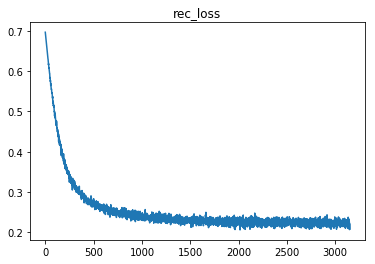

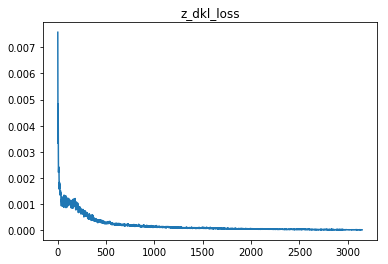

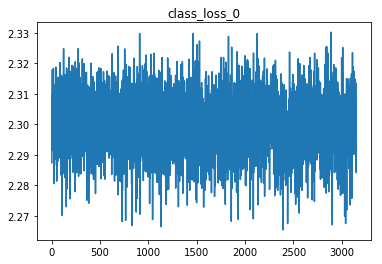

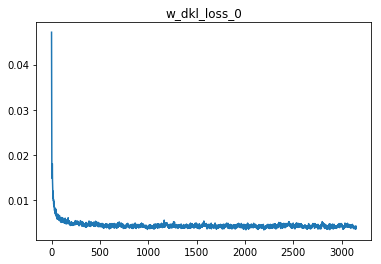

In [6]:
%matplotlib inline
losses = defaultdict(list)
losses_names = train_losses[0]._fields
print(losses_names)
step_loss = train_losses[0]
print(*step_loss)
for i, loss_name in enumerate(losses_names):
    losses[loss_name] = [l[i] for l in train_losses]
    plt.figure()
    plt.title(loss_name)
    plt.plot(losses[loss_name])
    plt.legend()
plt.show()

## 6 - Test

In [11]:
y_test = lb.transform(y_test)
losses, acc = model.test(torch.from_numpy(X_test).float(), [torch.from_numpy(y_test).float()])
pprint.PrettyPrinter(indent=4).pprint(losses)

Losses(rec_loss=tensor(0.2668), z_dkl_loss=tensor(0.0000), class_loss_0=tensor(2.3001), w_dkl_loss_0=tensor(0.0041))


## 7 - Examples

In [ ]:
#TODO

